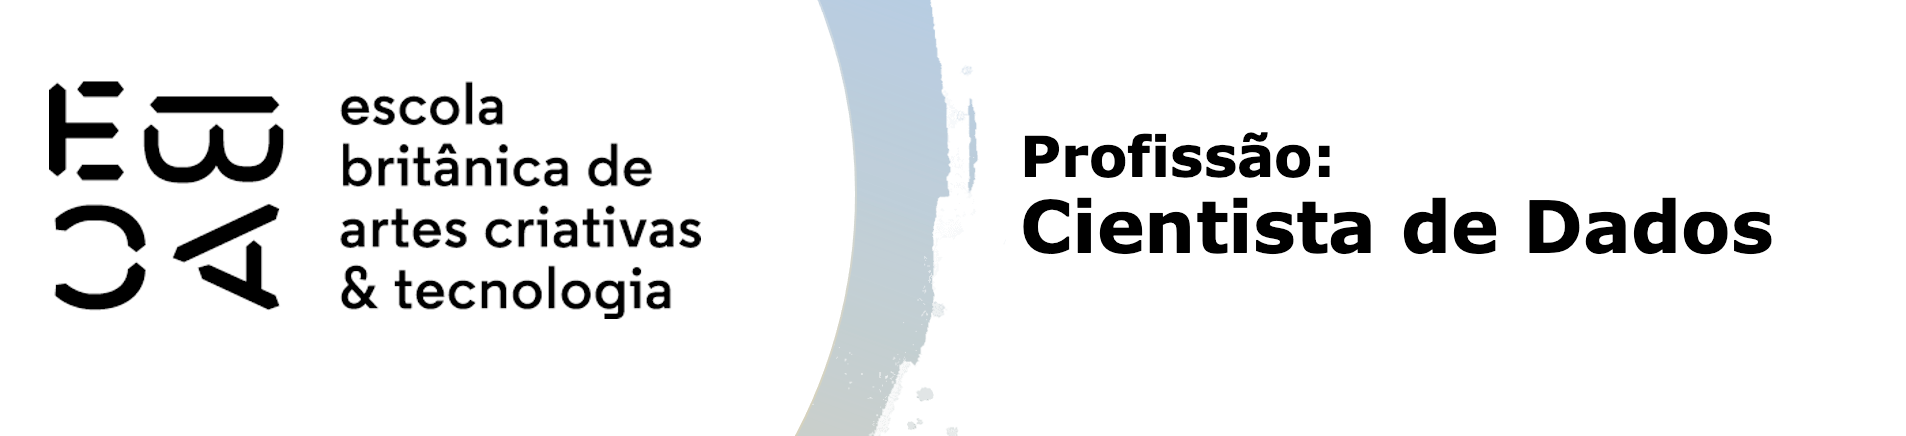

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelo de previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('Dados/previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [3]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())

In [4]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [5]:
# descobre os 3 últimos meses únicos presentes no DataFrame
ultimos_meses = df.index.to_period('M').unique()[-3:]

# filtra linhas cujo mês está entre os 3 últimos meses
df_teste = df[df.index.to_period('M').isin(ultimos_meses)]
df_treino = df[~df.index.to_period('M').isin(ultimos_meses)]

In [6]:
# cria colunas do log de renda para treino e teste
df_treino['log_renda'] = np.log(df_treino['renda'])
df_teste['log_renda'] = np.log(df_teste['renda'])

C:\Users\henri\AppData\Local\Temp\ipykernel_13704\3218005598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treino['log_renda'] = np.log(df_treino['renda'])
C:\Users\henri\AppData\Local\Temp\ipykernel_13704\3218005598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['log_renda'] = np.log(df_teste['renda'])


In [7]:
# separa X e y
y_treino = df_treino['log_renda']
y_teste = df_teste['log_renda']

X_treino = df_treino.drop(columns=['renda', 'log_renda'])
X_teste = df_teste.drop(columns=['renda', 'log_renda'])

In [8]:
# transforma variáveis categóricas em dummies
X_treino = pd.get_dummies(X_treino, drop_first=True)
X_teste = pd.get_dummies(X_teste, drop_first=True)

In [9]:
# garante que as colunas sejam as mesmas nas duas bases
X_treino, X_teste = X_treino.align(X_teste, join='left', axis=1, fill_value=0)

In [10]:
# cria e treina o modelo
modelo = LinearRegression()
modelo.fit(X_treino, y_treino)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [11]:
y_pred = modelo.predict(X_teste)

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

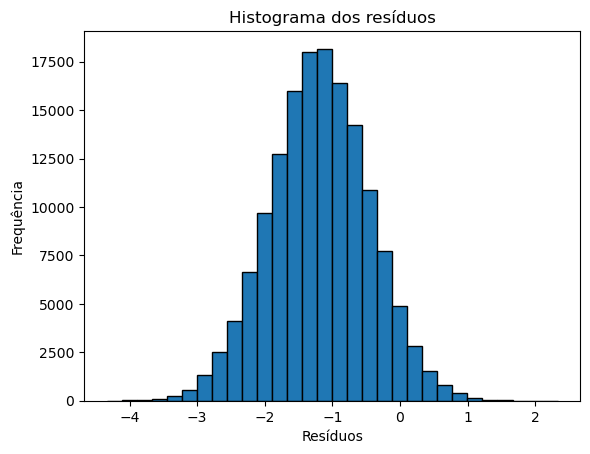

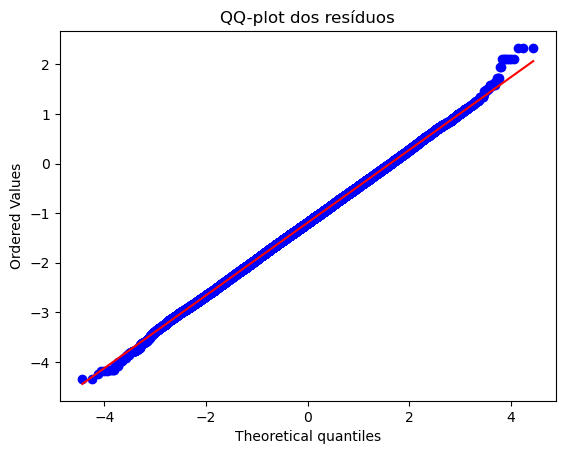

In [12]:
residuos = y_teste - y_pred

plt.hist(residuos, bins=30, edgecolor='k')
plt.title("Histograma dos resíduos")
plt.xlabel("Resíduos")
plt.ylabel("Frequência")
plt.show()

stats.probplot(residuos, dist="norm", plot=plt)
plt.title("QQ-plot dos resíduos")
plt.show()

Os resíduos do modelo apresentam boa normalidade, visto que o histograma apresenta pouca assimetria e os pontos do QQ-plot estão bem alinhados com a linha vermelha

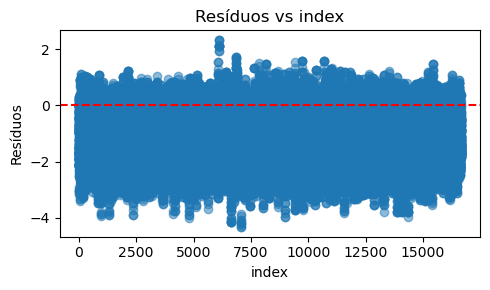

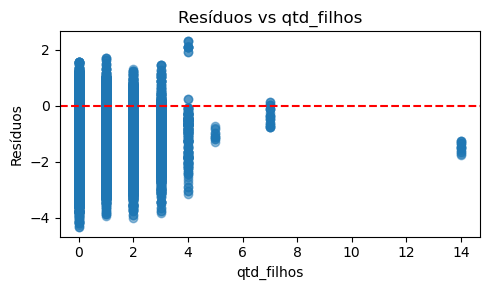

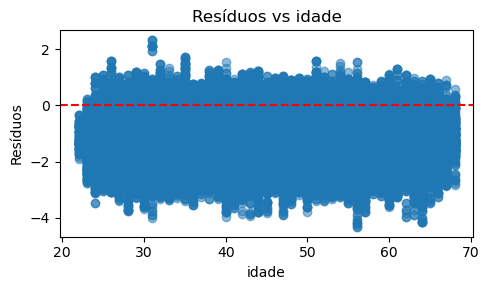

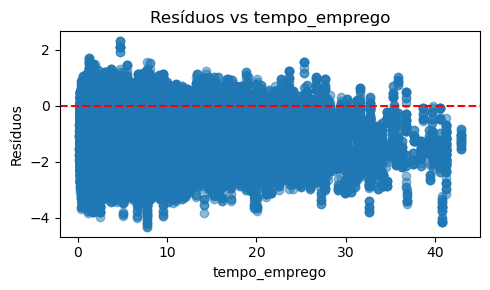

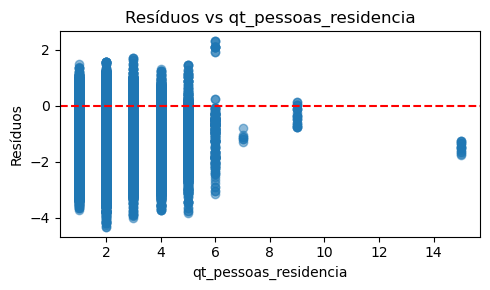

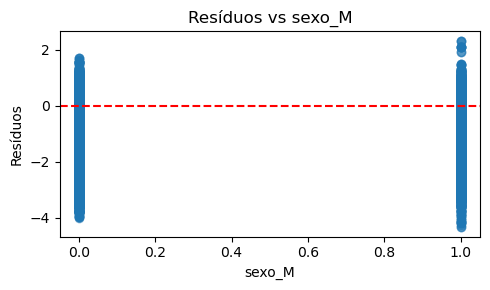

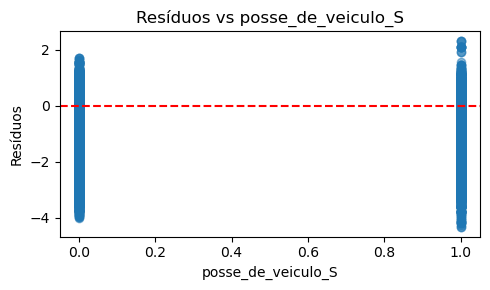

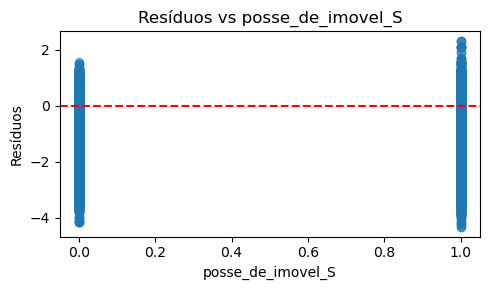

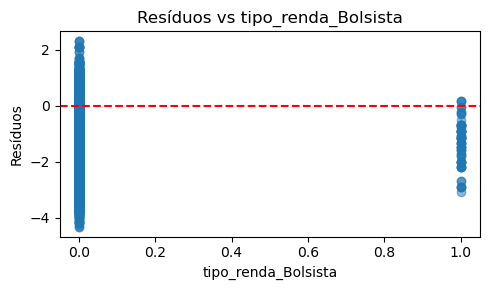

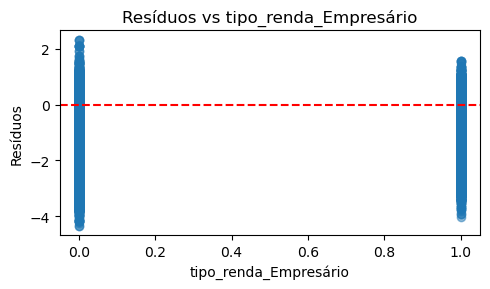

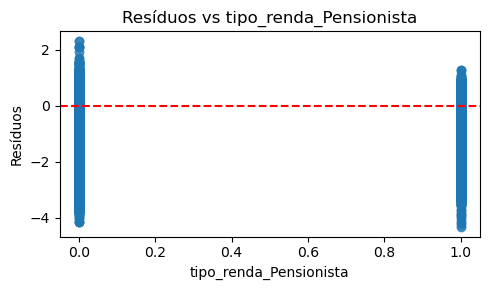

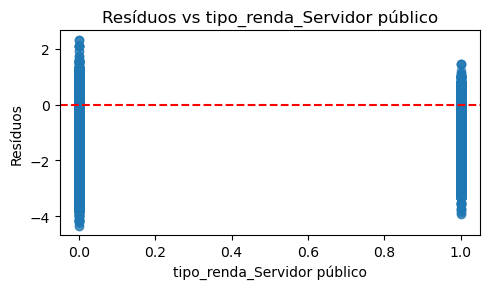

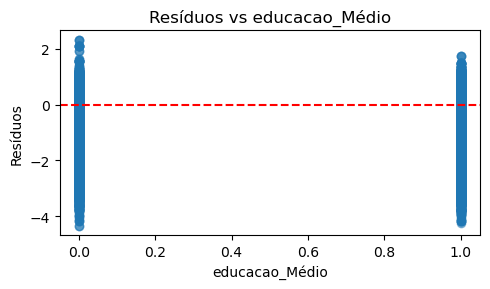

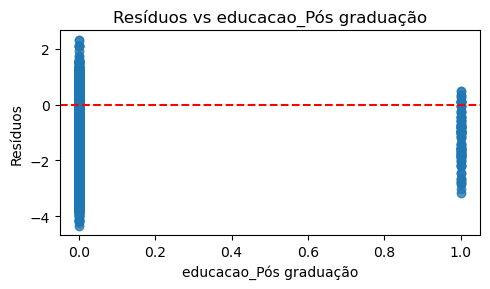

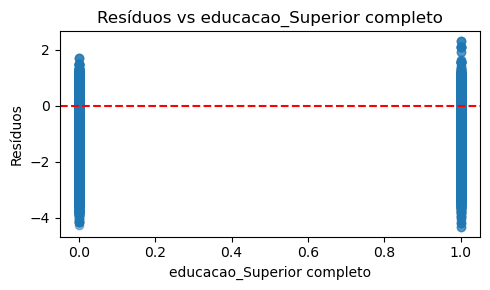

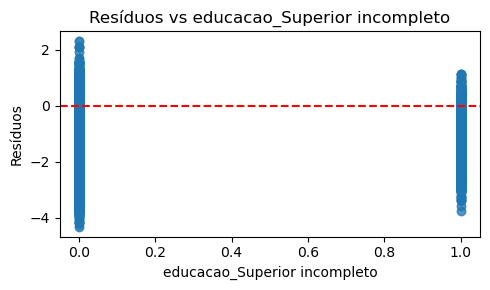

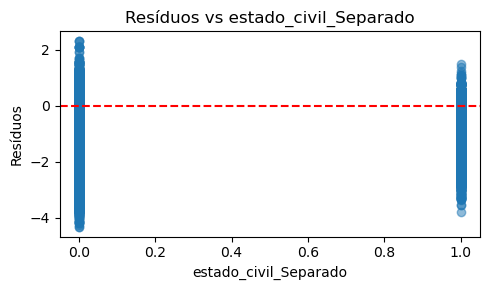

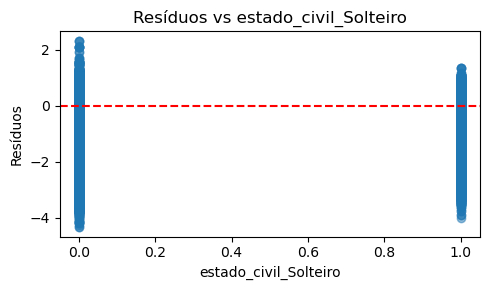

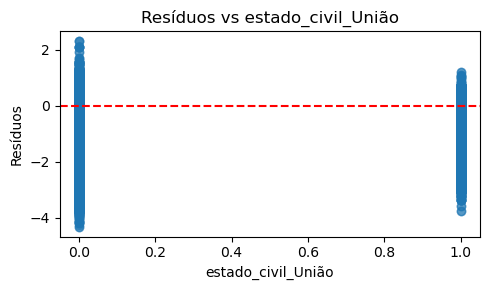

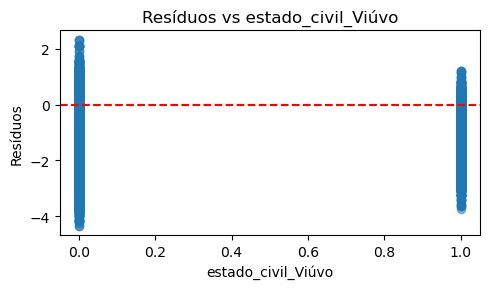

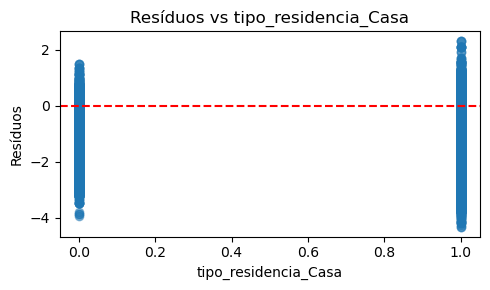

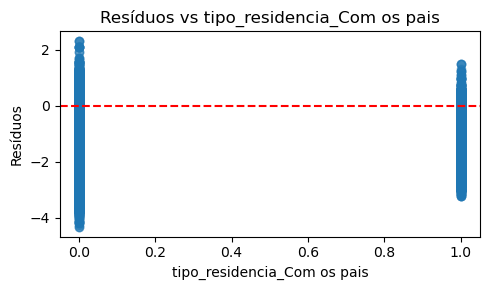

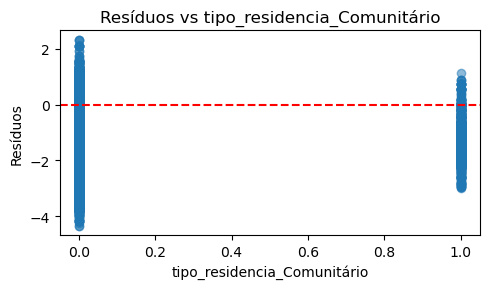

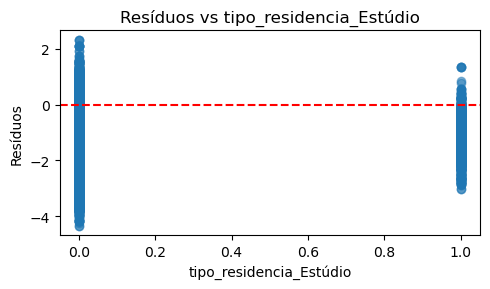

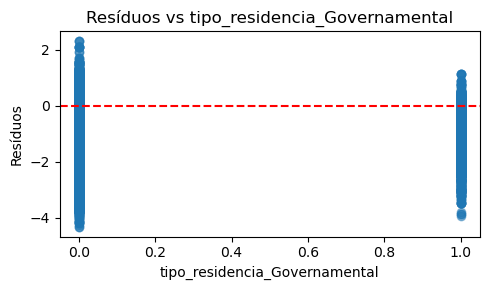

In [13]:
for coluna in X_teste.columns:
    plt.figure(figsize=(5, 3))
    plt.scatter(X_teste[coluna], residuos, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(coluna)
    plt.ylabel("Resíduos")
    plt.title(f"Resíduos vs {coluna}")
    plt.tight_layout()
    plt.show()

C:\Users\henri\AppData\Local\Temp\ipykernel_13704\2316796077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['residuos'] = residuos


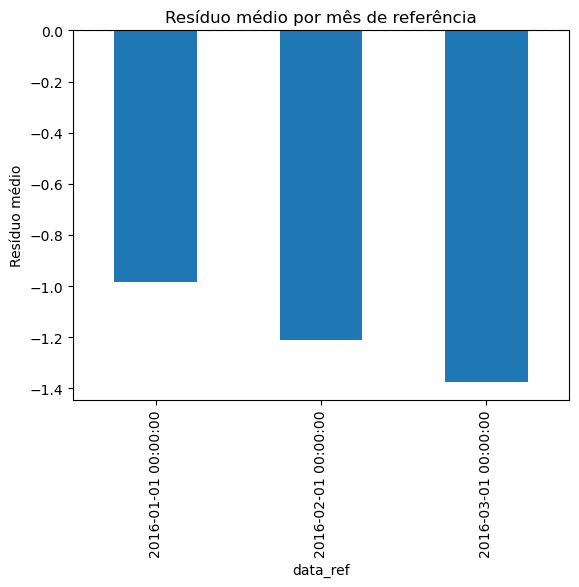

In [14]:
df_teste['residuos'] = residuos

media_residuos_mes = df_teste.groupby(df_teste.index)['residuos'].mean()

media_residuos_mes.plot(kind='bar')
plt.ylabel('Resíduo médio')
plt.title('Resíduo médio por mês de referência')
plt.axhline(0, color='red', linestyle='--')
plt.show()

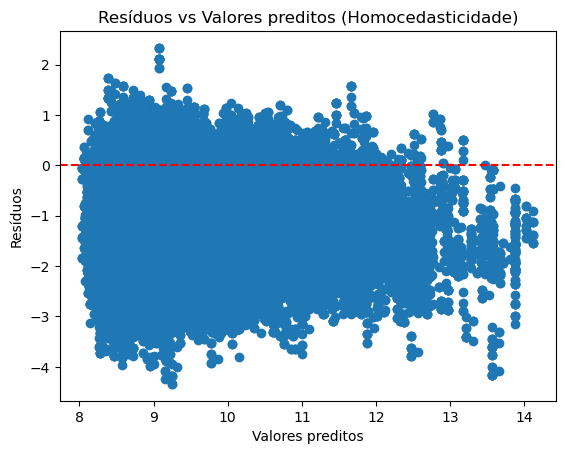

In [15]:
# avaliando se a variância da variável resposta parece ser conforme os valores previstos.
plt.scatter(y_pred, residuos)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores preditos")
plt.ylabel("Resíduos")
plt.title("Resíduos vs Valores preditos (Homocedasticidade)")
plt.show()

O gráfico de resíduos vs valores previstos mostra os resíduos distribuídos de forma aleatória e com variância praticamente constante, sem indícios de heterocedasticidade ou padrão claro.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

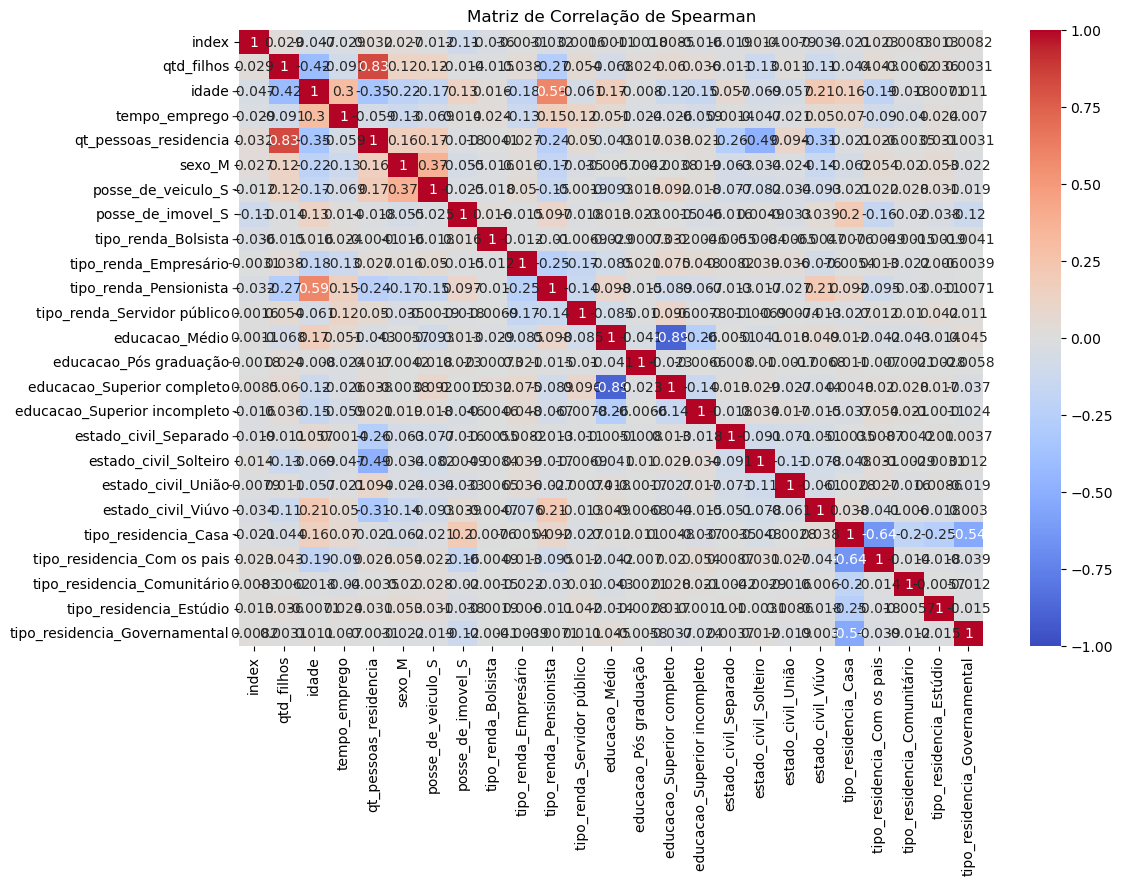

In [16]:
# matriz de correlação de Spearman
matriz_corr_spearman = X_treino.corr(method='spearman')

plt.figure(figsize=(12,8))
sns.heatmap(matriz_corr_spearman, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Matriz de Correlação de Spearman')
plt.show()

Há uma correlação alta entre qt_pessoas_residencia X qtd_filhos e tipo_renda_Pensionista X idade (multicolinearidade)

In [22]:
X_treino_numeric = X_treino.astype(float)
print(X_treino_numeric.dtypes)

index                            float64
qtd_filhos                       float64
idade                            float64
tempo_emprego                    float64
qt_pessoas_residencia            float64
sexo_M                           float64
posse_de_veiculo_S               float64
posse_de_imovel_S                float64
tipo_renda_Bolsista              float64
tipo_renda_Empresário            float64
tipo_renda_Pensionista           float64
tipo_renda_Servidor público      float64
educacao_Médio                   float64
educacao_Pós graduação           float64
educacao_Superior completo       float64
educacao_Superior incompleto     float64
estado_civil_Separado            float64
estado_civil_Solteiro            float64
estado_civil_União               float64
estado_civil_Viúvo               float64
tipo_residencia_Casa             float64
tipo_residencia_Com os pais      float64
tipo_residencia_Comunitário      float64
tipo_residencia_Estúdio          float64
tipo_residencia_

In [24]:
# VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X_treino_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_treino_numeric.values, i) for i in range(X_treino_numeric.shape[1])]
print(vif_data)

                          feature         VIF
0                           index    4.057864
1                      qtd_filhos   34.992341
2                           idade   34.680295
3                   tempo_emprego    3.024512
4           qt_pessoas_residencia  245.377828
5                          sexo_M    1.822163
6              posse_de_veiculo_S    1.968871
7               posse_de_imovel_S    3.275068
8             tipo_renda_Bolsista    1.005371
9           tipo_renda_Empresário    1.477593
10         tipo_renda_Pensionista    2.196960
11    tipo_renda_Servidor público    1.206236
12                 educacao_Médio   52.825444
13         educacao_Pós graduação    1.091358
14     educacao_Superior completo   28.627674
15   educacao_Superior incompleto    4.338189
16          estado_civil_Separado    3.506229
17          estado_civil_Solteiro    5.906156
18             estado_civil_União    1.124613
19             estado_civil_Viúvo    3.001239
20           tipo_residencia_Casa 

O VIF confirma a presença de multicolinearidade severa em variáveis como qt_pessoas_residencia, educacao_Superior completo, educacao_Médio, etc. Isso indica que algumas variáveis estão fortemente relacionadas, o que pode aumentar a instabilidade das estimativas.

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [25]:
# define a lista de colunas a remover 
colunas_para_remover = ['qt_pessoas_residencia', 'educacao_Superior completo', 'educacao_Médio']

# remove dos conjuntos de treino e teste
X_treino_ajustado = X_treino.drop(columns=colunas_para_remover)
X_teste_ajustado = X_teste.drop(columns=colunas_para_remover)

# treina o modelo ajustado
modelo_ajustado = LinearRegression()
modelo_ajustado.fit(X_treino_ajustado, y_treino)

y_pred_ajustado = modelo_ajustado.predict(X_teste_ajustado)

In [34]:
# calculo das métricas
print('Modelo original:')
print('R2:', r2_score(y_teste, y_pred))
print('RMSE:', mean_squared_error(y_teste, y_pred))
print('MAE:', mean_absolute_error(y_teste, y_pred))

print('\nModelo ajustado:')
print('R2:', r2_score(y_teste, y_pred_ajustado))
print('RMSE:', mean_squared_error(y_teste, y_pred_ajustado))
print('MAE:', mean_absolute_error(y_teste, y_pred_ajustado))

Modelo original:
R2: -0.640557024229206
RMSE: 1.953909320936387
MAE: 1.2225261047956302

Modelo ajustado:
R2: -0.621579511671442
RMSE: 1.9313070351717552
MAE: 1.2134753946706762
